# Comparison between real loss and DA loss

In [1]:
# Base libraries
import math
import numpy as np
import scipy.integrate as integrate
from tqdm import tqdm
from scipy.special import erf
import pickle
import itertools

# Personal libraries
import sixtrackwrap as sx

import time
import matplotlib.pyplot as plt

## Parameters

In [2]:
min_turns = 100
max_turns = 1000
n_turn_samples = 10

turn_sampling = np.linspace(min_turns, max_turns, n_turn_samples, dtype=np.int_)[::-1]

d_r = 1.0
starting_step = 10 # USE IT CAREFULLY AS IT REQUIRES PRIOR KNOWLEDGE ON DA

batch_size = 50000

baseline_samples = 17
baseline_total_samples = baseline_samples ** 3

### Setup and everything goes...

In [3]:
alpha_preliminary_values = np.linspace(-1.0, 1.0, baseline_samples)
alpha_values = np.arccos(alpha_preliminary_values) / 2
theta1_values = np.linspace(0.0, np.pi * 2.0, baseline_samples, endpoint=False)
theta2_values = np.linspace(0.0, np.pi * 2.0, baseline_samples, endpoint=False)

d_preliminar_alpha = alpha_preliminary_values[1] - alpha_preliminary_values[0]
d_theta1 = theta1_values[1] - theta1_values[0]
d_theta2 = theta2_values[1] - theta2_values[0]

alpha_mesh, theta1_mesh, theta2_mesh = np.meshgrid(alpha_values, theta1_values, theta2_values, indexing='ij')

alpha_flat = alpha_mesh.flatten()
theta1_flat = theta1_mesh.flatten()
theta2_flat = theta2_mesh.flatten()

In [ ]:
# Data generation
engine = sx.radial_scanner(alpha_flat, theta1_flat, theta2_flat, d_r, starting_step=starting_step)

engine.scan(max_turns, min_turns, batch_size=batch_size)

radiuses = engine.extract_DA(turn_sampling)
radiuses = radiuses.reshape((baseline_samples, baseline_samples, baseline_samples, len(turn_sampling)))

Active radiuses: 4913 / 4913
Sample size per active radius: 11
Expected execution time for step: nan


In [55]:
DA = []

mod_radiuses = radiuses.copy()
mod_radiuses = np.power(radiuses, 4)
mod_radiuses1 = integrate.simps(mod_radiuses, x=theta1_values, axis=1)
mod_radiuses2 = integrate.simps(mod_radiuses1, x=theta2_values, axis=1)
mod_radiuses3 = integrate.simps(mod_radiuses2, x=alpha_preliminary_values, axis=0)

for i in range(len(turn_sampling)):
    DA.append(
        np.power(
            mod_radiuses3[i] / (2 * theta1_values[-1] * theta2_values[-1]),
            1/4
        )
    )

DA = np.asarray(DA)

## Attempt with simple gaussian

In [86]:
sigma = 30

# a = - np.exp(- 1 ** 2 / 2) * (1 ** 2 + 2) + 2

# Cursed Sanity Check
def loss_from_DA(DA_list, DA_max):
    temp = - np.exp(- ((DA_list / sigma) ** 2) / 2) * (DA_list ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2
    return np.concatenate((temp, [- np.exp(- ((DA_max / sigma) ** 2) / 2) * (DA_max ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2]))

values = loss_from_DA(DA, 40.0)
values /= values[-1]
values

array([0.17136481, 0.17871447, 0.1858069 , 0.19610725, 0.20802822,
       0.2248595 , 0.24807118, 0.28202807, 0.32760983, 0.42009854,
       1.        ])

In [87]:
engine.assign_weights(
    lambda r, a, b, c: - np.exp(- ((r / sigma) ** 2) / 2) * (r ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2
)

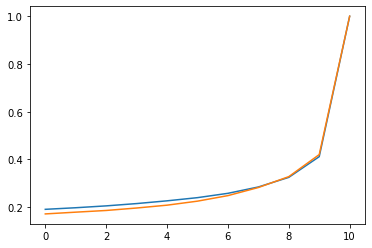

In [88]:
real_values = engine.compute_loss(turn_sampling, 40)
real_values
plt.plot(real_values)
plt.plot(values)

### If we manipulate things?

In [42]:
actual_turns = engine.steps.copy()
for i in range(engine.steps.shape[0]):
    engine.steps[i] = np.linspace(100, 5, engine.steps.shape[1])

radiuses = engine.extract_DA(turn_sampling)
radiuses = radiuses.reshape((baseline_samples, baseline_samples, baseline_samples, len(turn_sampling)))    

DA = []

mod_radiuses = radiuses.copy()
mod_radiuses = np.power(radiuses, 4)
mod_radiuses1 = integrate.simps(mod_radiuses, x=theta1_values, axis=1)
mod_radiuses2 = integrate.simps(mod_radiuses1, x=theta2_values, axis=1)
mod_radiuses3 = integrate.simps(mod_radiuses2, x=alpha_preliminary_values, axis=0)

for i in range(len(turn_sampling)):
    DA.append(
        np.power(
            mod_radiuses3[i] / (2 * theta1_values[-1] * theta2_values[-1]),
            1/4
        )
    )

DA = np.asarray(DA)

In [45]:
sigma = 10

# a = - np.exp(- 1 ** 2 / 2) * (1 ** 2 + 2) + 2

# Cursed Sanity Check
def loss_from_DA(DA_list, DA_max):
    temp = - np.exp(- ((DA_list / sigma) ** 2) / 2) * (DA_list ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2
    return np.concatenate((temp, [- np.exp(- ((DA_max / sigma) ** 2) / 2) * (DA_max ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2]))

values = loss_from_DA(DA, 65.0)
values /= values[-1]
values

array([0.09020401, 0.36607496, 0.69588808, 0.90238183, 0.97905852,
       0.99698085, 0.99970566, 0.9999805 , 0.99999913, 0.99999999,
       1.        ])

In [46]:
engine.assign_weights(
    lambda r, a, b, c: - np.exp(- ((r / sigma) ** 2) / 2) * (r ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2
)

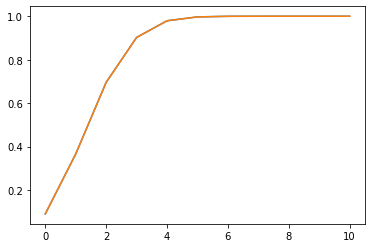

In [47]:
real_values = engine.compute_loss(turn_sampling, 65)
real_values
plt.plot(real_values)
plt.plot(values)

In [48]:
real_values

array([0.09020401, 0.36607496, 0.69588809, 0.90238184, 0.97905854,
       0.99698086, 0.99970567, 0.99998052, 0.99999914, 1.        ,
       1.        ])

In [49]:
values

array([0.09020401, 0.36607496, 0.69588808, 0.90238183, 0.97905852,
       0.99698085, 0.99970566, 0.9999805 , 0.99999913, 0.99999999,
       1.        ])

## Basic Old Stuff

In [34]:
# Cursed Sanity Check
def loss_from_DA(DA_list, DA_max):
    temp = np.power(DA_list, 4)
    return np.concatenate((temp, [np.power(DA_max, 4)]))

values = loss_from_DA(DA, 66.0)
values /= values[-1]
values

array([0.01599477, 0.01675922, 0.01750214, 0.01859011, 0.0198625 ,
       0.0216829 , 0.02423867, 0.02807075, 0.0333861 , 0.04476662,
       1.        ])

In [35]:
engine.assign_weights(
    lambda r, a, b, c: r
)

In [37]:
real_values = engine.compute_loss(turn_sampling, 66.0)
real_values

array([0.01866472, 0.01939989, 0.02028202, 0.02137876, 0.02270046,
       0.02424771, 0.02634898, 0.02951721, 0.03448097, 0.04593857,
       1.        ])

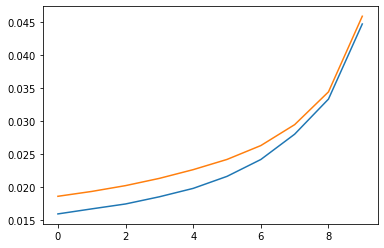

In [39]:
plt.plot(values[:-1])
plt.plot(real_values[:-1])

In [9]:
def compute_loss(sample_list):
    values = np.empty(len(sample_list) + 1)
    values[-1] = sum([np.sum(weight) for weight in engine.weights])
    for i, sample in enumerate(sample_list):
        values[i] = np.sum(
            [np.sum(engine.weights[j] * (engine.steps[j] >= sample)) for j in range(len(engine.weights))]
            )
    values /= values[-1]
    return values    
compute_loss(turn_sampling)

array([0.01656386, 0.01721628, 0.01799912, 0.01897241, 0.02014534,
       0.02151844, 0.0233832 , 0.02619482, 0.03059986, 0.04076783,
       1.        ])

In [92]:
test = np.linspace(1,10,100)
double_test = np.array([test for i in range(10)])

In [95]:
retest = double_test ** 4
retest[:,1:] = np.diff(retest, axis=1)
retest = np.cumsum(retest, axis=1)
retest = np.sum(retest, axis=0)
retest /= retest[-1]
retest

array([1.00000000e-04, 1.41629670e-04, 1.95075473e-04, 2.62386449e-04,
       3.45775562e-04, 4.47619698e-04, 5.70459668e-04, 7.17000205e-04,
       8.90109965e-04, 1.09282153e-03, 1.32833140e-03, 1.60000000e-03,
       1.91135168e-03, 2.26607472e-03, 2.66802131e-03, 3.12120757e-03,
       3.62981354e-03, 4.19818318e-03, 4.83082440e-03, 5.53240899e-03,
       6.30777269e-03, 7.16191517e-03, 8.10000000e-03, 9.12735469e-03,
       1.02494707e-02, 1.14720033e-02, 1.28007718e-02, 1.42417594e-02,
       1.58011133e-02, 1.74851445e-02, 1.93003278e-02, 2.12533024e-02,
       2.33508708e-02, 2.56000000e-02, 2.80078205e-02, 3.05816269e-02,
       3.33288778e-02, 3.62571955e-02, 3.93743665e-02, 4.26883410e-02,
       4.62072331e-02, 4.99393211e-02, 5.38930469e-02, 5.80770166e-02,
       6.25000000e-02, 6.71709309e-02, 7.20989072e-02, 7.72931904e-02,
       8.27632061e-02, 8.85185438e-02, 9.45689570e-02, 1.00924363e-01,
       1.07594843e-01, 1.14590643e-01, 1.21922171e-01, 1.29600000e-01,
      

In [96]:
coso = np.power(np.linspace(1,10,100), 4)
coso /= coso[-1]
coso[::]

array([1.00000000e-04, 1.41629670e-04, 1.95075473e-04, 2.62386449e-04,
       3.45775562e-04, 4.47619698e-04, 5.70459668e-04, 7.17000205e-04,
       8.90109965e-04, 1.09282153e-03, 1.32833140e-03, 1.60000000e-03,
       1.91135168e-03, 2.26607472e-03, 2.66802131e-03, 3.12120757e-03,
       3.62981354e-03, 4.19818318e-03, 4.83082440e-03, 5.53240899e-03,
       6.30777269e-03, 7.16191517e-03, 8.10000000e-03, 9.12735469e-03,
       1.02494707e-02, 1.14720033e-02, 1.28007718e-02, 1.42417594e-02,
       1.58011133e-02, 1.74851445e-02, 1.93003278e-02, 2.12533024e-02,
       2.33508708e-02, 2.56000000e-02, 2.80078205e-02, 3.05816269e-02,
       3.33288778e-02, 3.62571955e-02, 3.93743665e-02, 4.26883410e-02,
       4.62072331e-02, 4.99393211e-02, 5.38930469e-02, 5.80770166e-02,
       6.25000000e-02, 6.71709309e-02, 7.20989072e-02, 7.72931904e-02,
       8.27632061e-02, 8.85185438e-02, 9.45689570e-02, 1.00924363e-01,
       1.07594843e-01, 1.14590643e-01, 1.21922171e-01, 1.29600000e-01,
      

In [23]:
selfo_temp = np.linspace(100, 10, 100)
selfo_steps = np.array([selfo_temp for i in range(17**3)])
selfo_starting_step = 1
selfo_dr = 0.01
DA = [np.argmax(selfo_temp < i) for i in [90, 50, 20]]


def loss_from_DA(DA_list, DA_max):
    temp = 2 * np.pi * np.pi * np.power(DA_list, 4)
    temp = np.concatenate((temp, [2 * np.pi * np.pi * np.power(DA_max, 4)]))
    return temp / temp[-1]

def assign_weights(f=lambda r, a, th1, th2: r):
    maximum = 0
    for i in range(len(selfo_steps)):
        maximum = max(maximum, len(selfo_steps[i]))

    selfo_weights = np.empty((len(selfo_steps), maximum))

    for i in range(len(selfo_steps)):
        selfo_weights[i] = np.array(
            [f(selfo_dr * (j + selfo_starting_step), 1, 1, 1) for j in range(maximum)]
            )
        selfo_weights[i] = np.power(selfo_weights[i], 4)
        selfo_weights[i][1:] = np.diff(selfo_weights[i])
    return selfo_weights

def compute_loss(selfo_weights, sample_list, cutting_point=-1.0):
    if cutting_point > selfo_starting_step:
        cutting_point = int((cutting_point - selfo_starting_step) / selfo_dr) + 1
    values = np.empty(len(sample_list) + 1)
    values[-1] = sum([np.sum(weight[:cutting_point]) for weight in selfo_weights])
    for i, sample in enumerate(sample_list):
        values[i] = np.sum(
            [np.sum(selfo_weights[j][:len(selfo_steps[j])] * (selfo_steps[j] >= sample))
                for j in range(len(selfo_weights))]
        )
    values /= values[-1]
    return values



In [24]:
loss_from_DA(DA, 1000)

array([2.0736000e-08, 9.8344960e-06, 6.2742241e-05, 1.0000000e+00])

In [25]:
selfo_weights = assign_weights()

In [27]:
compute_loss(selfo_weights, DA[::-1], 1000)

array([2.8561000e-04, 5.7648010e-02, 8.8529281e-01, 1.0000000e+00])

In [ ]:
sum([np.sum(selfo_weights[j][:len(selfo_steps[j])] * (selfo_steps[j] >= 50)) for j in tqdm(range(len(selfo_weights)))])

In [ ]:
selfo_weights[j]

In [3]:
from scipy.stats import multivariate_normal
from scipy import integrate

In [13]:
func = multivariate_normal(
    [0.0, 0.0, 0.0, 0.0],
    [[1.0, 0.0, 0.0, 0.0],
     [0.0, 1.0, 0.0, 0.0],
     [0.0, 0.0, 1.0, 0.0],
     [0.0, 0.0, 0.0, 1.0]])

def func_all(r, a, t1, t2):
    x  = r * np.cos(a) * np.cos(t1)
    px = r * np.cos(a) * np.sin(t1)
    y  = r * np.sin(a) * np.cos(t2)
    py = r * np.sin(a) * np.sin(t2)
    return func.pdf([x, px, y, py]) * 

func_np = np.vectorize(func_all)

a = integrate.nquad(
    func_np,
    [[0, 1], [0, np.pi/2], [0, 2 * np.pi], [0, 2 * np.pi]]
)

b = integrate.nquad(
    func_np,
    [[0, 2], [0, np.pi/2], [0, 2 * np.pi], [0, 2 * np.pi]]
)

a[0] / b[0]

0.7152327720109058

In [14]:
a = - np.exp(- 1 ** 2 / 2) * (1 ** 2 + 2) + 2
b = - np.exp(- 2 ** 2 / 2) * (2 ** 2 + 2) + 2
c = - np.exp(- 20 ** 2 / 2) * (20 ** 2 + 2) + 2
print(a, b, c)
print(a / b)

0.18040802086209973 1.1879883005803238 2.0
0.1518600989369775


In [3]:
test = np.linspace(1,2,100)

retest = test.copy()

retest[0] = - np.exp(- test[0] ** 2 / 2) * (test[0] ** 2 + 2) + 2
retest[1:] = - np.exp(- test[1:] ** 2 / 2) * (test[1:] ** 2 + 2) + np.exp(- test[:-1] ** 2 / 2) * (test[:-1] ** 2 + 2) 

#print(test)
#print(retest)

retest = np.cumsum(retest)
print(retest[0] / retest[-1])

0.15186009893697747


In [86]:
retest = func_np(double_test, np.zeros_like(double_test),np.zeros_like(double_test),np.zeros_like(double_test))
#retest[1:] = np.diff(retest)
#retest = np.cumsum(retest)
#retest = np.sum(retest)
#retest /= retest[-1]
retest

array([1.53636011e-02, 1.39706657e-02, 1.25994610e-02, 1.12693178e-02,
       9.99664043e-03, 8.79470562e-03, 7.67360310e-03, 6.64030682e-03,
       5.69885689e-03, 4.85062996e-03, 4.09467397e-03, 3.42808277e-03,
       2.84638775e-03, 2.34394605e-03, 1.91430861e-03, 1.55055467e-03,
       1.24558394e-03, 9.92361051e-04, 7.84110390e-04, 6.14462659e-04,
       4.77556293e-04, 3.68098832e-04, 2.81394170e-04, 2.13342087e-04,
       1.60416403e-04, 1.19627712e-04, 8.84760268e-05, 6.48978358e-05,
       4.72112616e-05, 3.40621289e-05, 2.43729871e-05, 1.72964318e-05,
       1.21734890e-05, 8.49736763e-06, 5.88253523e-06, 4.03882889e-06,
       2.75015494e-06, 1.85724697e-06, 1.24392142e-06, 8.26279581e-07,
       5.44342051e-07, 3.55653871e-07, 2.30459165e-07, 1.48105510e-07,
       9.43972276e-08, 5.96702767e-08, 3.74082725e-08, 2.32588396e-08,
       1.43423139e-08, 8.77124402e-09, 5.32002842e-09, 3.20020280e-09,
       1.90920182e-09, 1.12963195e-09, 6.62876897e-10, 3.85779894e-10,
      

In [96]:
coso = np.power(np.linspace(1,10,100), 4)
coso /= coso[-1]
coso[::]

array([1.00000000e-04, 1.41629670e-04, 1.95075473e-04, 2.62386449e-04,
       3.45775562e-04, 4.47619698e-04, 5.70459668e-04, 7.17000205e-04,
       8.90109965e-04, 1.09282153e-03, 1.32833140e-03, 1.60000000e-03,
       1.91135168e-03, 2.26607472e-03, 2.66802131e-03, 3.12120757e-03,
       3.62981354e-03, 4.19818318e-03, 4.83082440e-03, 5.53240899e-03,
       6.30777269e-03, 7.16191517e-03, 8.10000000e-03, 9.12735469e-03,
       1.02494707e-02, 1.14720033e-02, 1.28007718e-02, 1.42417594e-02,
       1.58011133e-02, 1.74851445e-02, 1.93003278e-02, 2.12533024e-02,
       2.33508708e-02, 2.56000000e-02, 2.80078205e-02, 3.05816269e-02,
       3.33288778e-02, 3.62571955e-02, 3.93743665e-02, 4.26883410e-02,
       4.62072331e-02, 4.99393211e-02, 5.38930469e-02, 5.80770166e-02,
       6.25000000e-02, 6.71709309e-02, 7.20989072e-02, 7.72931904e-02,
       8.27632061e-02, 8.85185438e-02, 9.45689570e-02, 1.00924363e-01,
       1.07594843e-01, 1.14590643e-01, 1.21922171e-01, 1.29600000e-01,
      